<b> Install Prophet </b>
https://facebook.github.io/prophet/docs/installation.html

<b> Reference </b> 
https://facebook.github.io/prophet/docs/quick_start.html#python-api

Data: https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather/data?select=weather_features.csv

In [73]:
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

<b> Data </b>

The input to Prophet is always a dataframe with two columns: `ds` and `y`. The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The `y` column must be numeric, and represents the measurement we wish to forecast.

As an example, let’s look at a time series of the log daily page views for the Wikipedia page for Peyton Manning. 

In [74]:
df = pd.read_csv('data/weather_features.csv')
df.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [75]:
df['dt_iso'] = pd.to_datetime(df['dt_iso'], utc=True, format='%Y-%m-%d %H:%M:%S%z')
df.dtypes

dt_iso                 datetime64[ns, UTC]
city_name                           object
temp                               float64
temp_min                           float64
temp_max                           float64
pressure                             int64
humidity                             int64
wind_speed                           int64
wind_deg                             int64
rain_1h                            float64
rain_3h                            float64
snow_3h                            float64
clouds_all                           int64
weather_id                           int64
weather_main                        object
weather_description                 object
weather_icon                        object
dtype: object

In [76]:
df['date'] = df['dt_iso'].dt.date
df['time'] = df['dt_iso'].dt.time

# pandas.Series.dt.date
# pandas.Series.dt.time
# pandas.Series.dt.timetz
# pandas.Series.dt.year
# pandas.Series.dt.month
# pandas.Series.dt.day
# pandas.Series.dt.hour
# pandas.Series.dt.minute
# pandas.Series.dt.second
# pandas.Series.dt.microsecond
# pandas.Series.dt.nanosecond
# pandas.Series.dt.dayofweek
# pandas.Series.dt.day_of_week
# pandas.Series.dt.weekday
# pandas.Series.dt.dayofyear
# pandas.Series.dt.day_of_year
# pandas.Series.dt.days_in_month
# pandas.Series.dt.quarter
# pandas.Series.dt.is_month_start
# pandas.Series.dt.is_month_end
# pandas.Series.dt.is_quarter_start
# pandas.Series.dt.is_quarter_end
# pandas.Series.dt.is_year_start
# pandas.Series.dt.is_year_end
# pandas.Series.dt.is_leap_year
# pandas.Series.dt.daysinmonth
# pandas.Series.dt.days_in_month
# pandas.Series.dt.tz
# pandas.Series.dt.freq
# pandas.Series.dt.unit
# pandas.Series.dt.isocalendar
# pandas.Series.dt.to_period
# pandas.Series.dt.to_pydatetime
# pandas.Series.dt.tz_localize
# pandas.Series.dt.tz_convert
# pandas.Series.dt.normalize
# pandas.Series.dt.strftime
# pandas.Series.dt.round
# pandas.Series.dt.floor
# pandas.Series.dt.ceil
# pandas.Series.dt.month_name
# pandas.Series.dt.day_name
# pandas.Series.dt.as_unit
# pandas.Series.dt.qyear
# pandas.Series.dt.start_time
# pandas.Series.dt.end_time
# pandas.Series.dt.days
# pandas.Series.dt.seconds
# pandas.Series.dt.microseconds
# pandas.Series.dt.nanoseconds
# pandas.Series.dt.components
# pandas.Series.dt.unit
# pandas.Series.dt.to_pytimedelta
# pandas.Series.dt.total_seconds
# pandas.Series.dt.as_unit

In [77]:
daily_average = df.groupby(['date','city_name']).agg({
    'temp': 'mean',
    'temp_min': 'mean',
    'temp_max': 'mean',
    'rain_1h': 'mean',
    'clouds_all':'mean'
}).reset_index()

In [78]:
daily_average.head()

,date,city_name,temp,temp_min,temp_max,rain_1h,clouds_all
0,2014-12-31,Barcelona,281.625000,281.625000,281.625000,0.0,0.0
1,2014-12-31,Bilbao,269.657312,269.657312,269.657312,0.0,0.0
2,2014-12-31,Madrid,267.325000,267.325000,267.325000,0.0,0.0
3,2014-12-31,Seville,273.375000,273.375000,273.375000,0.0,0.0
4,2014-12-31,Valencia,270.475000,270.475000,270.475000,0.0,0.0


In [79]:
daily_madrid = daily_average[daily_average['city_name']=='Madrid']


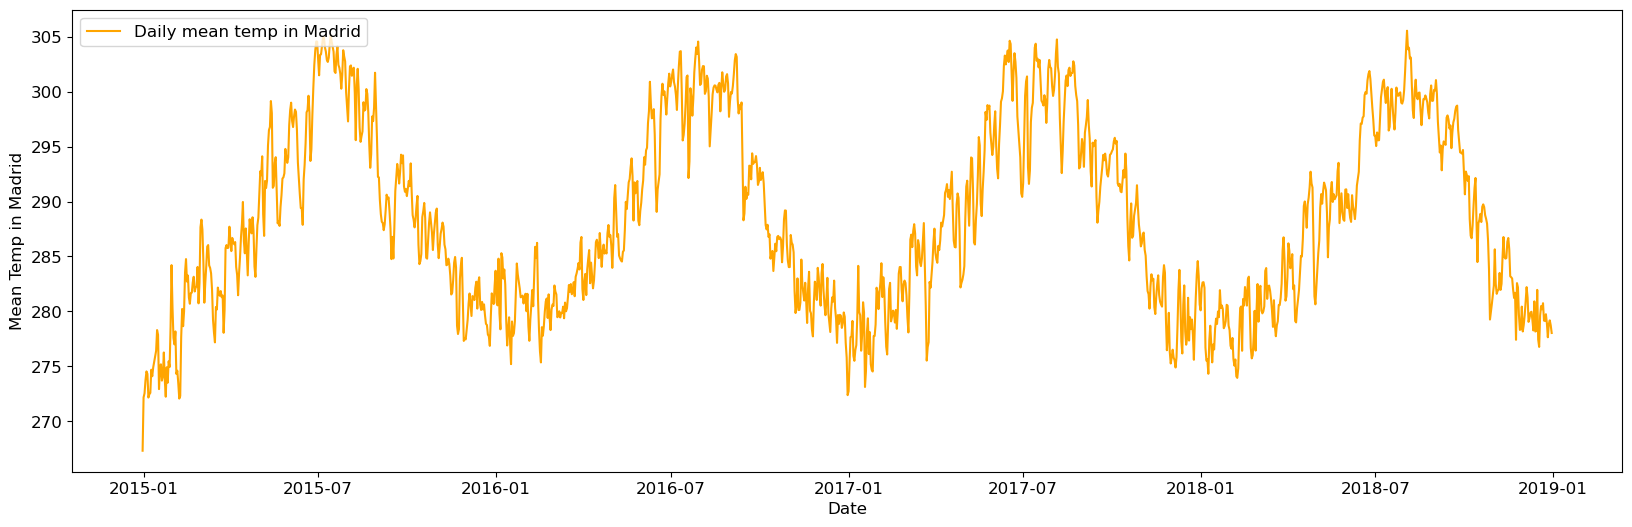

In [80]:
#see the TS plot

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(daily_madrid.date, daily_madrid.temp, color='orange', label='Daily mean temp in Madrid')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Temp in Madrid')
ax.legend(loc='upper left')

<b> I. Forecasting </b>

The basic model fitting and forecasting can be done by 

- creating a new Prophet project
- call `fit` to fit on the given historic data
- predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made.

By default, Prophet uses the piecewise linear model for its forecast

In [81]:
#Prophet project
model_data=daily_madrid.rename(columns={'date': 'ds', 'temp': 'y'}).reset_index()

model = Prophet() #default trend = piece-wise linear model
                #default include weekly and yearly seasonalities

#Fit with default settings
model.add_seasonality(name='yearly', period=365, fourier_order=10)

model.fit(model_data)


#Fataframe with forecasting steps
future = model.make_future_dataframe(periods=365) #freq='D'
#Forecast
forecast = model.predict(future)
# fig = model.plot_components(forecast)


12:32:48 - cmdstanpy - INFO - Chain [1] start processing
12:32:48 - cmdstanpy - INFO - Chain [1] done processing


In [106]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.to_csv('output/forecast_1y.csv', index=False)

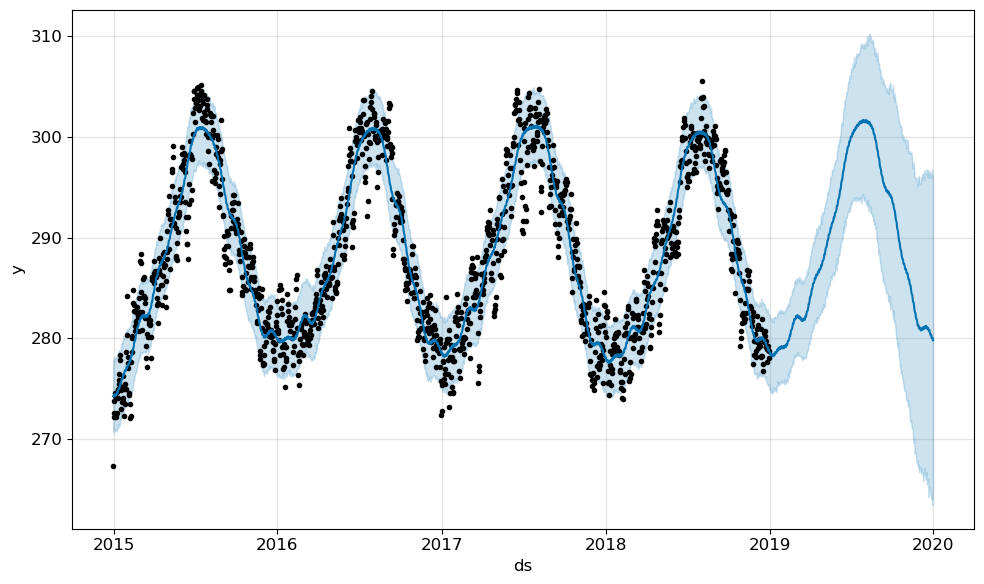

In [107]:
fig1 = model.plot(forecast)
fig1.savefig('fig/forecast_plot.png', dpi=300, bbox_inches='tight')


<b> VI. Cross Validation in Prophet </b>

Prophet includes functionality for time series cross validation to measure forecast error using historical data. You need choose:

- Initial train size
- Horizon: the period you want to forecast
- Period: the size of rolling window


In [84]:
model_data.iloc[731]

index               3657
ds            2016-12-31
city_name         Madrid
y             272.384074
temp_min      271.409259
temp_max      274.261111
rain_1h              0.0
clouds_all     30.185185
Name: 731, dtype: object

In [97]:
from prophet.diagnostics import cross_validation
forecast_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')


  0%|          | 0/3 [00:00<?, ?it/s]

12:37:17 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] done processing
12:37:18 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] done processing
12:37:18 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] done processing


In [98]:
print(model_data.shape)
model_data

(1462, 8)


,index,ds,city_name,y,temp_min,temp_max,rain_1h,clouds_all
0,2,2014-12-31,Madrid,267.325000,267.325000,267.325000,0.0,0.000000
1,7,2015-01-01,Madrid,272.176652,272.176652,272.176652,0.0,0.000000
2,12,2015-01-02,Madrid,272.546417,272.546417,272.546417,0.0,5.291667
3,17,2015-01-03,Madrid,273.754031,273.754031,273.754031,0.0,0.000000
4,22,2015-01-04,Madrid,274.543271,274.543271,274.543271,0.0,0.000000
...,...,...,...,...,...,...,...,...
1457,7287,2018-12-27,Madrid,277.649167,276.587500,279.045833,0.0,6.166667
1458,7292,2018-12-28,Madrid,278.839167,277.691667,280.275000,0.0,6.000000
1459,7297,2018-12-29,Madrid,279.189167,278.233333,280.358333,0.0,0.000000
1460,7302,2018-12-30,Madrid,278.730417,277.316667,280.775000,0.0,0.000000


In [103]:
forecast_cv
forecast_cv.to_csv('output/forecast_cross_validation.csv', index=False)


In [104]:
#check performance 

from prophet.diagnostics import performance_metrics
forecast_perf = performance_metrics(forecast_cv) #by default start with 10% of the horizon
forecast_perf.to_csv('output/forecast_performance_metrics.csv', index=False)


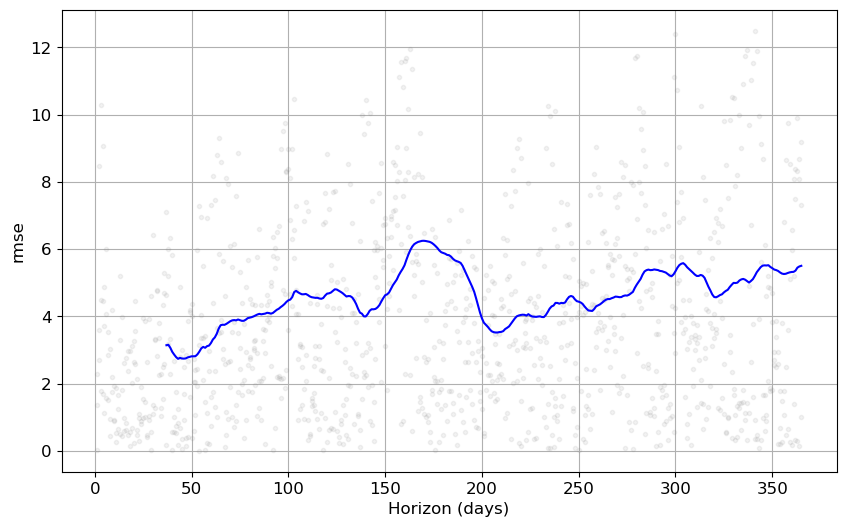

In [105]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(forecast_cv, metric='rmse')